# Model description
Below, a mesa implementation is given of Eppstein's Civil Violence model 2. This model is focused on the emergence of civil war and ethnic cleansing. The basic idea of this model is the following. We have 2 types of agents: cops (or peace keepers) and citizens. Cops and Citizens both have a field of vision and they move every step to a random empty location within their field of vision. Citizens come in 2 colors: blue and green. Citizens have grievances and this might cause them to become active. In this version of the model, if a citizen becomes active this means that they kill an agent of the other color within their field of vision.

## Citizen
Citizens can kill (i.e., becomes $active$). They decide every tick, after having moved, whether or not they want to kill. If they decide to kill another agent, they pick a random agent within their vision of the other color. They have a preference for killing active agents of the active color, but if none of those are available within their field of vision, they will settle on killing any agent of the other color.

They make the decision whether or not to kill based on their attributes. 

- attributes with unique values for each citizen:
    - hardship, drawn from $U(0, 1)$
    - risk aversion, drawn from $U(0, 1)$
- attributes with shared values across all Citizens (i.e. class level attributes):
    - perception of the legitimacy of the State, a user specified parameter between 0 and 1. 
    - threshold above which Citizens will protest, a user specified parameter usually set to a small positive value (e.g., 0.1).

An agent will try to kill if: (Grievance - Net Risk) > Threshold. Otherwise the agent is $quiet$. Only if an agent has succesfully killed an agent is it considered to be active.

**Grievance** is calculated for each citizen as: 

$
    grievance = hardship * (1-legitimacy)
$

The **net risk** is the perceived chance of being arrested times the personal level of risk aversion. The perceived chance of being arrested is given by

$
    p = 1 - e^{(-1*k*round(c/a))}
$

Where:
- $k$ is an arrest probability constant (set to 2.3 as default), 
- $c$ is the number of cops within the field of vision,
- $a$ is the number of active citizens within the field of vision including the agent itself (who considers herself always active).

So the net risk is:

$
net\_risk = p * risk\_aversion
$

## Cop
After having moved, the cop checks his field of vision for any active citizens. It then arrests a randomly selected active citizen within its field of vision. 

## Arrest
If a citizen is arrested, it cannot move. Upon arrest, a citizen also receives a random jail time, which is the number of ticks for which it remains under arrest. Jail time is drawn from $U(U, J_{max})$, where $J_{max}$ is a user specified parameter which can substantially alter the dynamics of the model. 

## population dynamics
Since in this model agents can be killed, there is a need to add some basic population dynamics. We do this as follows. First, at every time step an agent has a small probability $p$ to spawn offspring. This offspring will be placed on an empty cell within the field of vision. This offspring also inherits the color and hardship level of its parent. Second, every agent has a lifetime drawn from $U(0, 100)$. If its lifetime is up, an agent dies of natural causes and is removed from the model.

# Implementation details.
The model below is an implementation of the civil violence model 2. Given that the movement behavior and the way in which agents update their field of vision is the same for both Citizens and Cops, this functionality is implemented in a BaseAgent class. The Cop class and Citizen class both extend this BaseAgent class and add their respective behavior to it. The model itself uses a SingleGrid toroidol space. Class level attributes are used for legitimacy, vision, $k$, and activation threshold. Statistics collection is done using so called anonymous, or lambda functions. 

Any bugs for question 1 are confined to ```Model.__init__```, ```Citizen.__init__```, ```Citizen.step```, and ```Cop.step```. So, there are **no** errors in the statistics collection (including the relevant code in ```Model.__init__```), the ```BaseAgent``` class, and the visualization code. 


In [1]:
import math
from enum import Enum
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


class CitizenState(Enum):
    ACTIVE = 1    
    QUIET = 2    
    ARRESTED = 3
    
class CitizenColor(Enum):
    BLUE = 0
    GREEN = 2

def count(model, color):
    """Counts the number of citizens with the user-defined state"""
    count = 0
    for agent in model.schedule.agents:
        if isinstance(agent, Cop):
            continue
        else:
            if agent.color == color:
                count += 1
    return count

class CivilViolence(Model):
    """Model class for Eppstein's Civil Violence model 2.
    

    """

    def __init__(self, height=40, width=40, citizen_density=0.7, citizen_vision=7,
                 legitimacy=0.82, cop_density=0.04, cop_vision=7,
                 max_jail_term=15, seed=None, torus=True):
        super().__init__(seed=seed)

        assert (citizen_density+cop_density) < 1
        
        # setup Citizen class attributes
        Citizen.vision = citizen_vision
        Citizen.legitimacy = legitimacy
        
        # setup Cop class attributes
        Cop.vision = cop_vision
        Cop.max_jail_term = max_jail_term

        # setup data collection
        model_reporters = {'green': lambda m: count(m, CitizenColor.GREEN),
                           'blue': lambda m: count(m, CitizenColor.BLUE),
                           'kills': lambda m: m.kills_per_tick}
       
        self.datacollector = DataCollector(model_reporters=model_reporters)
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=torus)
        self.kills_per_tick = 0

        # Set up agents
        self.counter = 0
        for (_, x, y) in self.grid.coord_iter():
            pos = (x,y)
            p = self.random.random()
            if p < citizen_density:
                color = self.random.choice([CitizenColor.BLUE, CitizenColor.GREEN])
                grievance = self.random.random()*(1-Citizen.legitimacy)
                agent = Citizen(self.increment_counter(), self, color, grievance)
            elif p < (citizen_density+cop_density):
                agent = Cop(self.increment_counter(), self)
            else:
                continue
            self.grid.position_agent(agent, (x, y))
            self.schedule.add(agent)
        
        self.datacollector.collect(self)

    def increment_counter(self):
        self.counter += 1
        return self.counter
        
    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)
        self.kills_per_tick = 0


class BaseAgent(Agent):
    '''Base Agent class implementing vision and moving
    
    Attributes
    ----------
    moore : boolean
    
    '''    
    moore = True
    
    def get_agents_in_vision(self):
        """
        identify cops and citizens by color within vision
        
        Returns
        -------
        dict with lists 
        
        """
        vision = defaultdict(list)
        
        for cell in self.model.grid.get_neighbors(self.pos,
                         moore=BaseAgent.moore, radius=self.__class__.vision):
            if isinstance(cell, Cop):
                vision['cops'].append(cell)
            else:
                vision[cell.color].append(cell)

                if cell.state == CitizenState.ACTIVE:
                    vision[CitizenState.ACTIVE].append(cell)    
        return vision
    
    def get_empty_cells_in_vision(self):
        empty = []
        for pos in self.model.grid.get_neighborhood(self.pos,
                        moore=BaseAgent.moore, radius=self.__class__.vision):        
            if self.model.grid.is_cell_empty(pos):
                empty.append(pos)
        return empty
    
    def move(self):
        """
        identify all empty cells within vision and move
        to a randomly selected one.
        """
        empty = self.get_empty_cells_in_vision()
        
        try:
            new_pos = self.random.choice(empty)
        except IndexError:
            pass # no empty grid cells within vision
        else:
            self.model.grid.move_agent(self, new_pos)
        
    
class Citizen(BaseAgent):
    '''Citizen class
    
    Attributes
    ----------
    legitimacy : boolean
    vision : int
    arrest_prob_constant : float
    activation_treshold : float
    grievance : float
    risk_aversion : float
    state : {CitizenState.QUIET, CitizenState.ACTIVE, CitizenState.ARRESTED }
    color : {CitizenColor.BLUE, CitizenColor.RED}
    jail_time_remaining  : int
    tick_of_death : int
    
    '''        
    legitimacy = 1
    vision = 1
    arrest_prob_constant = 2.3
    activation_threshold = 0.1
    max_life = 100
    birth_probability = 1/47
    
    def __init__(self, identity, model, color, grievance):
        super().__init__(identity, model)
        self.risk_aversion = self.random.random()
        self.state = CitizenState.QUIET
        self.jail_time_remaining = 0
        self.grievance = grievance
        self.color = color
        self.tick_of_death = self.model.schedule.time + self.random.randint(0, self.max_life)

    def die(self):
        self.model.schedule.remove(self)
        self.model.grid.remove_agent(self)
        
    def spawn(self):
        empty = self.get_empty_cells_in_vision()
        
        if empty:
            agent = Citizen(self.model.increment_counter(), self.model, self.color, self.grievance)
            pos = self.random.choice(empty)
            self.model.grid.position_agent(agent, pos)
            self.model.schedule.add(agent)

    def kill_agent(self, agent_to_kill):
        self.state = CitizenState.ACTIVE                
        agent_to_kill.die()
        self.model.kills_per_tick += 1
            
    def step(self):
        """
        move and then decide whether to activate
        """
        if self.model.schedule.time == self.tick_of_death:
            self.die()        
            return
        if (self.state == CitizenState.ARRESTED) and (self.jail_time_remaining > 0):
            self.jail_time_remaining -= 1
            if self.jail_time_remaining > 0:
                return
        if self.random.random() < self.birth_probability:
            self.spawn()
            
        self.move()
            
        vision = self.get_agents_in_vision()
        n_cops = len(vision['cops'])
        n_active_citizens = len(vision['active']) + 1 # self is always considerd active
            
        arrest_p = 1 - math.exp(-1*Citizen.arrest_prob_constant * round(n_cops / n_active_citizens))
        net_risk = self.risk_aversion * arrest_p
        
        self.state = CitizenState.QUIET
        if (self.grievance - net_risk) > self.activation_threshold:
            if self.color == CitizenColor.BLUE:
                others = vision[CitizenColor.GREEN]
            else:
                others = vision[CitizenColor.BLUE]

            other_active = set(others) & set(vision[CitizenState.ACTIVE])
            if other_active: # empty set is False
                others = list(other_active)
                
            try:
                agent_to_kill = self.random.choice(others)
            except IndexError:
                pass # others is empty
            else:
                self.kill_agent(agent_to_kill)

            
class Cop(BaseAgent):
    '''Cop class
    
    Attributes
    ----------
    vision : int
    max_jail_term : int
    '''
    vision = 1
    max_jail_term = 1
        
    def arrest_citizen(self, citizen):
        citizen.state = CitizenState.ARRESTED
        citizen.jail_time_remaining = self.random.randint(0, Cop.max_jail_term)
        
    def step(self):
        self.move()
        vision = self.get_agents_in_vision()
        
        try:
            to_be_arrested = self.random.choice(vision['active'])
        except IndexError:
            pass # no active citizend
        else:
            self.arrest_citizen(to_be_arrested)

            
def visualize_model(model):
    sns.set_style('white')
    colors = sns.color_palette()
    
    # if the plot is not nice given your window size
    # consider changing figsize, but keep the ratio intact
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 25))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    positions = []
    color_type = []
    grievance_level = []
    
    for i, (cell, x,y) in enumerate(model.grid.coord_iter()):
        if not cell:
            continue
        
        positions.append([x,y])
        if isinstance(cell, Citizen):
            if cell.state == CitizenState.ACTIVE:
                index = 3
            elif cell.state == CitizenState.ARRESTED:
                index = 1
            elif cell.color == CitizenColor.BLUE:
                index = 0
            else:
                index = 2
                
            color_type.append(colors[index])
            grievance_level.append(cell.grievance)
        else:
            color_type.append(colors[5])
            grievance_level.append(np.NaN) #dirty hack for masking
    
    positions = np.asarray(positions)
    
    ax1.scatter(positions[:, 0], positions[:, 1], s=25, c=color_type)
    im = ax2.scatter(positions[:, 0], positions[:, 1], s=25, c=grievance_level)
    
    for ax in (ax1, ax2):
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax1.set_title('Agent states')
    ax2.set_title('grievance view')

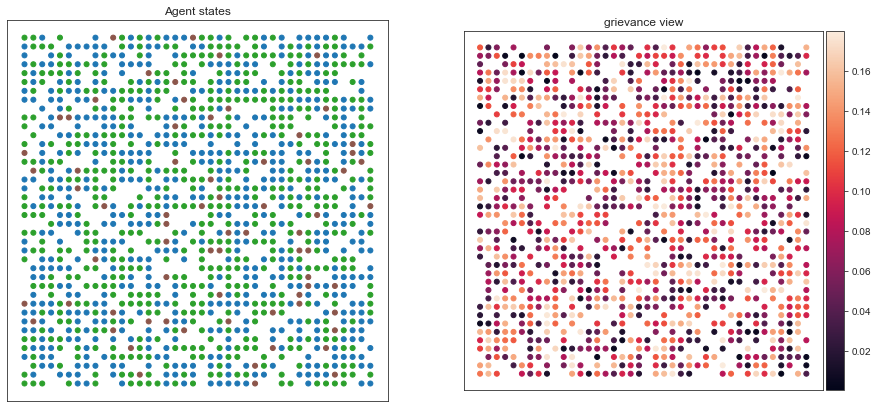

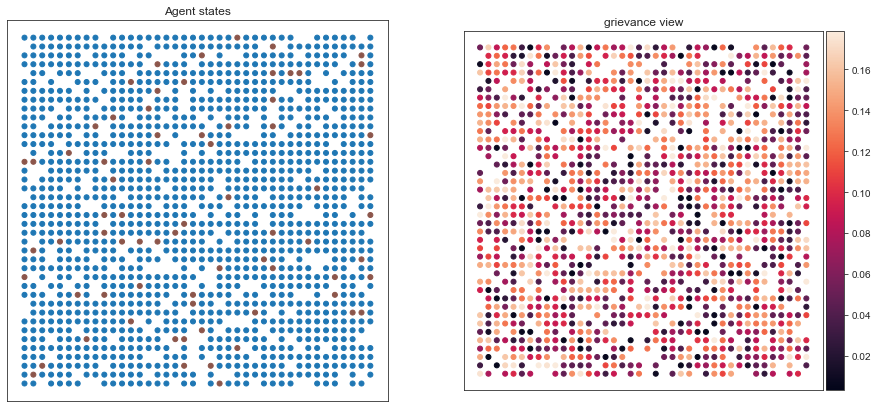

In [2]:
model = CivilViolence(cop_vision=5, citizen_vision=5, legitimacy=0.82,
                      max_jail_term=30, cop_density=0.04, citizen_density=0.7,
                      seed=123456789, torus=True)
visualize_model(model)

for _ in range(250):
    model.step()
visualize_model(model)

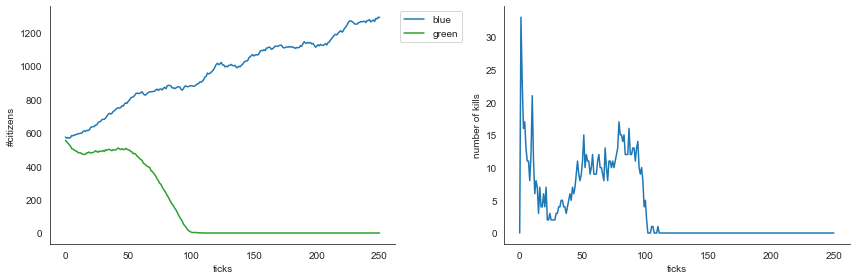

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
colors = sns.color_palette()

data = model.datacollector.get_model_vars_dataframe()
data[['blue', 'green']].plot(ax=ax1, color=[colors[0], colors[2]])

ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_xlabel('ticks')
ax1.set_ylabel('#citizens')

ax2.plot(data.kills)
ax2.set_xlabel('ticks')
ax2.set_ylabel('number of kills')

sns.despine()
plt.tight_layout()

plt.savefig('modeloutputs')

plt.show()

# option 1
The default model uses a toroidal grid. However, in the real-world borders or physical obstacles like mountain ranges or large rivers can affect where people live. Explore the behavior of the model for both the toroidal and non-toroidal case. Visually show the change in behavior and explain your results.

In [25]:
import random
from collections import defaultdict

nr_of_seeds = 10
seeds = [random.randint(1, 1000) for i in range(nr_of_seeds)]

genocide_complete = defaultdict(list)

for torus in [True, False]:
    for seed in seeds:
        model = CivilViolence(cop_vision=5, citizen_vision=5, legitimacy=0.82,
                              max_jail_term=30, cop_density=0.04, citizen_density=0.7,
                              seed=seed, torus=torus)

        for tick in range(250):
            model.step()
            if np.any(model.datacollector.get_model_vars_dataframe().loc[tick, ['green', 'blue']] == 0):
                break
        genocide_complete[torus].append(tick)
        


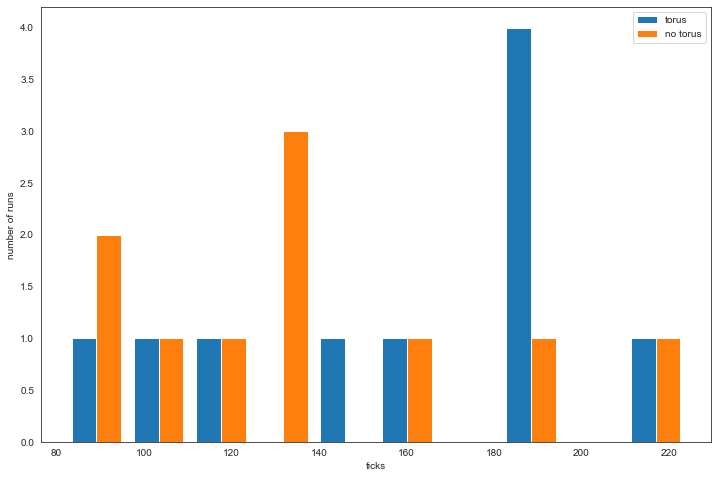

In [45]:
fig, ax = plt.subplots()

ax.hist([genocide_complete[True], genocide_complete[False]],
        label=['torus', 'no torus'])
ax.set_xlabel('ticks')
ax.set_ylabel('number of runs')

ax.legend()
plt.show()

# option 2
The default setup of the model uses a fixed ratio of 70% agents, and 4% cops, leaving 26% of the grid cells empty. How does the behavior of the model change if we move from 4% to 8% cops? In answering this question, ensure that 26% of your initial grid cells remains empty. Visually show the change in behavior and explain your results

In [50]:
import random
from collections import defaultdict

nr_of_seeds = 10
seeds = [random.randint(1, 1000) for i in range(nr_of_seeds)]

genocide_complete = defaultdict(list)

for densities in [(0.04, 0.7), (0.08, 0.66)]:
    for seed in seeds:
        cop_d, cit_d = densities
        
        model = CivilViolence(cop_vision=5, citizen_vision=5, legitimacy=0.82,
                              max_jail_term=30, cop_density=cop_d, citizen_density=cit_d,
                              seed=seed)

        for tick in range(250):
            model.step()
            if np.any(model.datacollector.get_model_vars_dataframe().loc[tick, ['green', 'blue']] == 0):
                break
        genocide_complete[cop_d].append(tick)
        



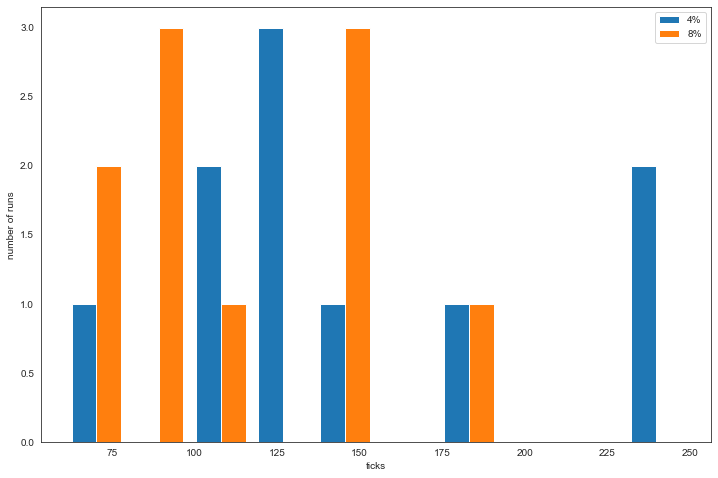

In [54]:
fig, ax = plt.subplots()

ax.hist([genocide_complete[0.04], genocide_complete[0.08]],
        label=['4%', '8%'])
ax.set_xlabel('ticks')
ax.set_ylabel('number of runs')

ax.legend()
plt.show()